In [40]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from plot import plot_histogram, \
      plot_hist_by_phenotype, plot_triadic_pattern_phenotype, plot_bar_diadic_pattern, \
      plot_xhi_by_phenotype, plot_diadic_pattern, plot_phenotype_combination_per_triangle, \
      plot_phenotype_combination_per_link, plot_triadic_pattern_phenotype_from_hist
from analysis import histogram, measure_global, compute_xhi_mean, compute_all_xhi_mean, compute_randomized
from graph import Network
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataset import Dataset, measure_frequency_diadic_pattern, \
      measure_global_frequency_triadic_pattern, \
      measure_triadic_pattern_phenotype_combination, measure_diadic_pattern_combination, \
      compute_triadic_histogram
import os
import networkx as nx


In [41]:
file = r"../out/last/RTH_E3O2P21R12T17_Empty_L10_C750_S50_T0.25_444675_distrib.h5"
net = Network()
net.reload_with_hdf5(file)

parameters = net.parameters
inter = parameters["Number of interaction"]
n = parameters["Community size"]
save = True

dirname = "distrib/" + "RTH_" + str(n)
if save:
    os.makedirs("../plot/" + dirname + "/", exist_ok=True)

In [42]:
t, l = net.get_trust_adjacency_matrix(), net.get_link_adjacency_matrix()
c = net.capacity_table
print(f"Number of interaction: ", inter)
print("Asymmetry rate: ", measure_global("Asymmetry", t, l, c, parameters))
print("Individual asymmetry rate: ", measure_global("Individual asymmetry", t, l, c, parameters))
print("Out preserving ind. asymmetry: ", measure_global("Individual asymmetry", t, l, c, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure_global("Saturation rate", t, l, c, parameters))
link_stat = measure_global("Number of link", t, l, c, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))
tri_pattern_freq = measure_global_frequency_triadic_pattern(l.astype(int), parameters, inter)
dtga = tri_pattern_freq.group_by("Transitive").aggregate("Number")
data = dtga.get_item(True).get_item("Number").get_all_item().values()
transitivity_rate = sum(data) / (n * (n-1) * (n-2) / 6)
print("Transitiviy rate: ", transitivity_rate)

Number of interaction:  444675
Asymmetry rate:  0.49415204678362573
Individual asymmetry rate:  0.27
Out preserving ind. asymmetry:  0.48
Saturation rate:  0.98
Mean number of link per agent:  20.6
Standard deviation number of link per agent:  32.80243893371345
Mean number of interaction per link:  363.0
Transitiviy rate:  0.21377551020408164


In [43]:
local_dt = Dataset("local", inter)
local_dt.init_with_network(net)

### Asymmetry per phenotype

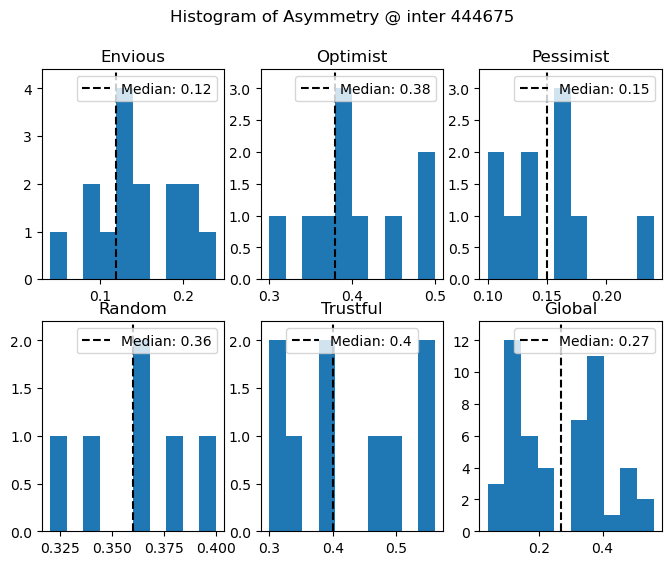

In [44]:
plot_hist_by_phenotype(local_dt, "Asymmetry")
if save:
    plt.savefig("../plot/" + dirname + "/asymmetry.png")
else:
    plt.show()

### Trust distribution

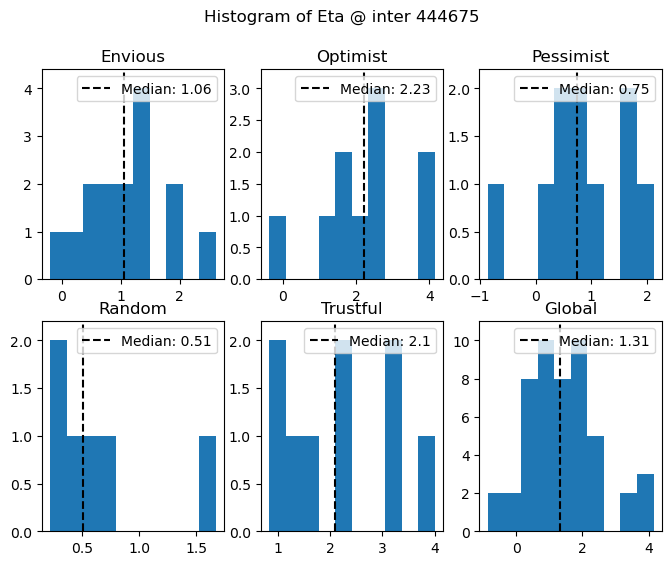

In [45]:
plot_hist_by_phenotype(local_dt, "Eta")
if save:
    plt.savefig("../plot/" + dirname + "/eta_histograms.png")
else:
    plt.show()

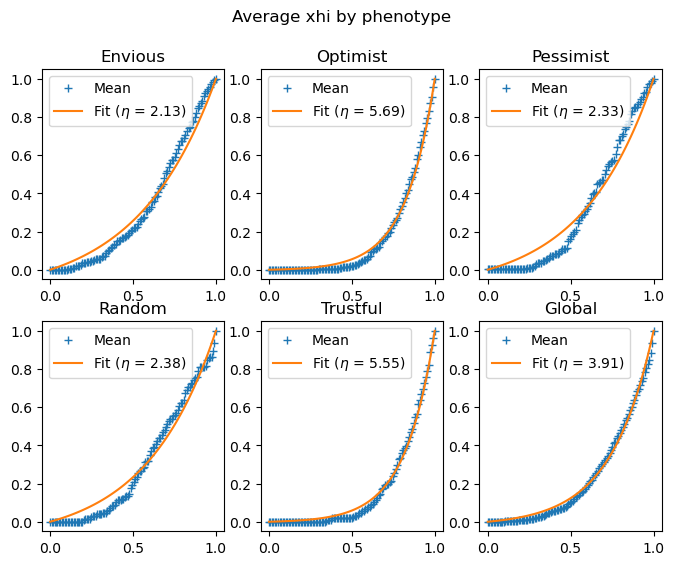

In [46]:
all_xhi = compute_all_xhi_mean(t, net.min_link_table, parameters)
plot_xhi_by_phenotype(all_xhi)
if save:
    plt.savefig("../plot/" + dirname + "/average_xhi_by_phenotype.png")
else:
    plt.show()

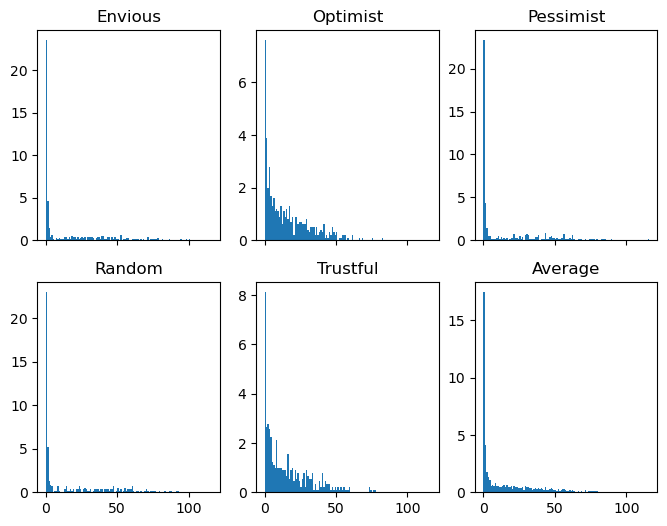

In [47]:
ph_mean = histogram(t, parameters)
fig, ax = plot_histogram(ph_mean, parameters, log=False, color="tab:blue")
plt.show()

### Centrality

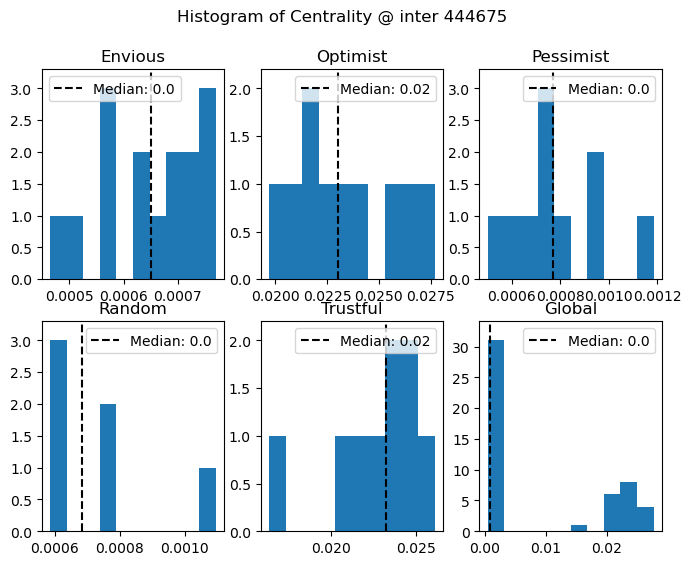

In [48]:
plot_hist_by_phenotype(local_dt, "Centrality")
if save:
    plt.savefig("../plot/" + dirname + "/Centrality histograms.png")
else:
    plt.show()

### Diadic pattern

In [49]:
di_pattern_freq = measure_frequency_diadic_pattern(l, parameters, inter)

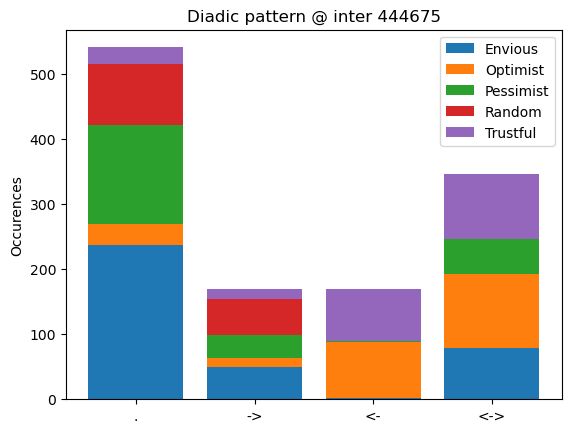

In [50]:
plot_bar_diadic_pattern(di_pattern_freq)
if save:
    plt.savefig("../plot/" + dirname + "/diadic_pattern_bar.png")
else:
    plt.show()

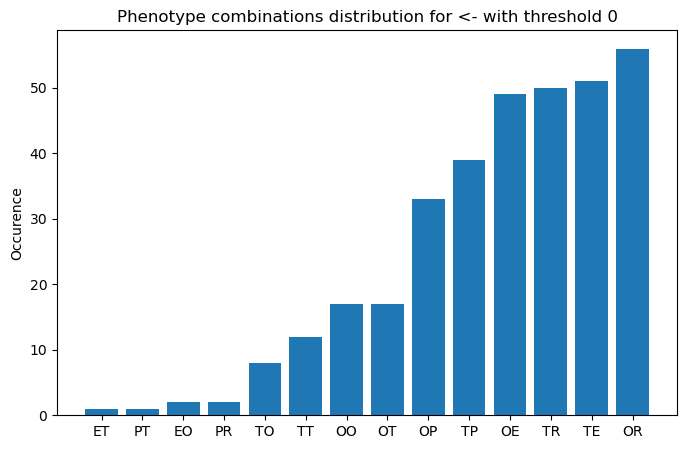

In [51]:
diadic_comb = measure_diadic_pattern_combination(l.astype(int), net.phenotypes_table, inter)
plot_phenotype_combination_per_link('<-', diadic_comb, 0)
plt.show()

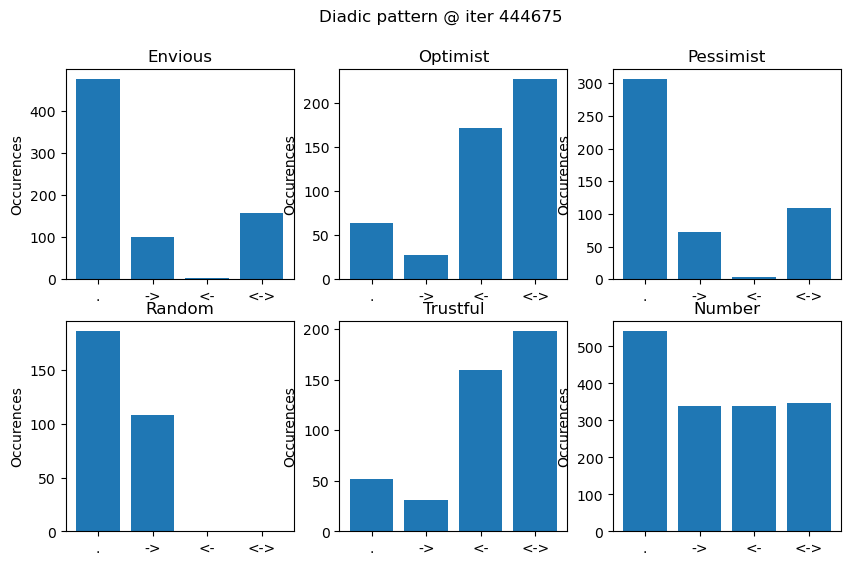

In [52]:
plot_diadic_pattern(di_pattern_freq)
plt.show()

### Triadic pattern

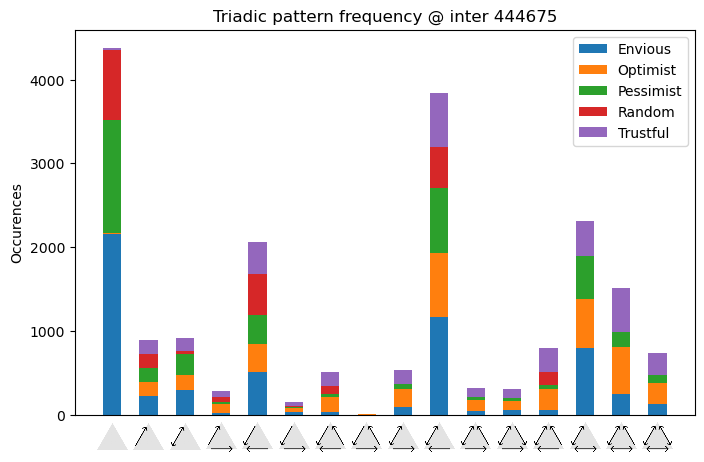

In [53]:
plot_triadic_pattern_phenotype(tri_pattern_freq, parameters)
if save:
    plt.savefig("../plot/" + dirname + "/triadic_pattern_bar.png")
else:
    plt.show()

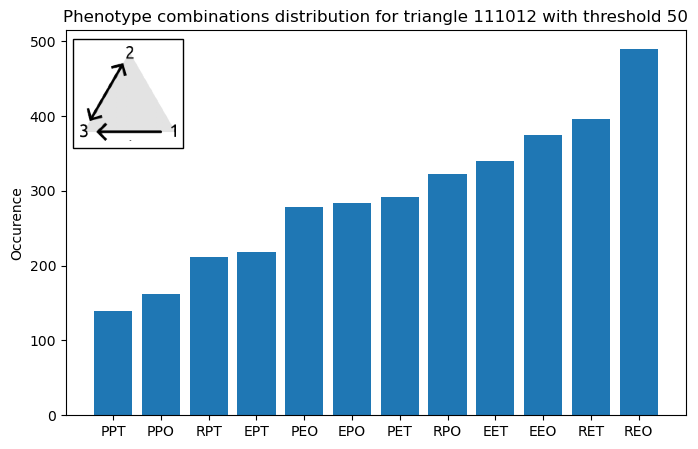

In [54]:
ph_comb_dt = measure_triadic_pattern_phenotype_combination(l.astype(int), parameters, inter)
plot_phenotype_combination_per_triangle("111012", ph_comb_dt, 50)
plt.show()

### Randomisation test

Test if the triadic distribution can be solely explained by the diadic one using `pn-link` randomisation. 

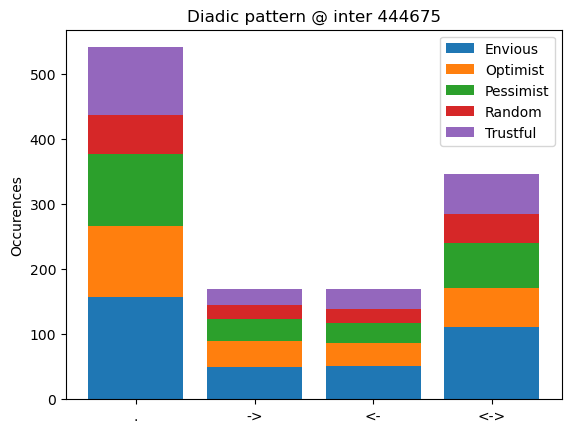

In [55]:
l_randomized = compute_randomized(l.astype(int), 'pn-link')
di_pattern_freq_rand = measure_frequency_diadic_pattern(l_randomized, parameters, inter)
plot_bar_diadic_pattern(di_pattern_freq_rand)

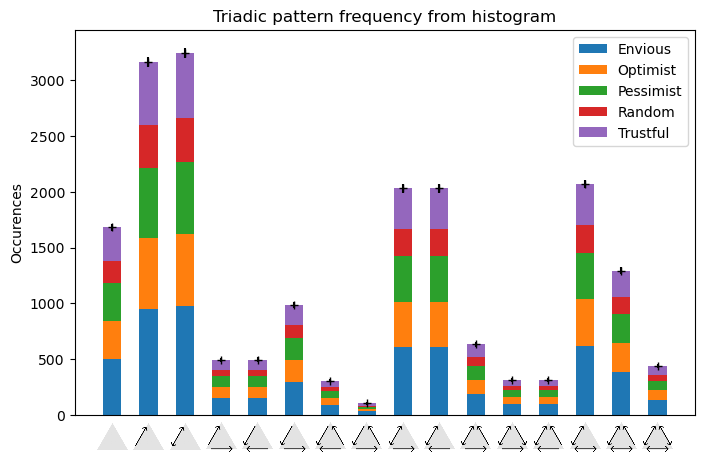

In [56]:
N = 1000
mean_freq = {ph: np.zeros(16) for ph in parameters["Strategy distributions"].keys()}
mean_freq["Number"] = np.zeros((N, 16))

for i in range(N):
    l_randomized = compute_randomized(l.astype(int), 'pn-link')
    tri_p = measure_global_frequency_triadic_pattern(l_randomized, parameters, inter)
    h, triangles = compute_triadic_histogram(tri_p, parameters)
    for key in h.keys():
        if key != "Number":
            mean_freq[key] += h[key] / N
        else:
            mean_freq[key][i] = h[key]

err = np.std(mean_freq["Number"], axis=0)
mean_freq["Number"] = np.mean(mean_freq["Number"], axis=0)

plot_triadic_pattern_phenotype_from_hist(mean_freq, triangles, err=err)
if save:
    plt.savefig("../plot/" + dirname + "/triadic_pattern_bar_randomized.png")
else:
    plt.show()


In [57]:
tri_pattern_freq = measure_global_frequency_triadic_pattern(l_randomized, parameters, inter)
dtga = tri_pattern_freq.group_by("Transitive").aggregate("Number")
data = dtga.get_item(True).get_item("Number").get_all_item().values()
transitivity_rate = sum(data) / (n * (n-1) * (n-2) / 6)
print("Transitiviy rate: ", transitivity_rate)

Transitiviy rate:  0.1692857142857143


### Clustering analysis

In [ ]:
G = nx.from_numpy_array(l)
communities = list(nx.community.girvan_newman(G))

KeyboardInterrupt: 

In [ ]:
print(len(communities))
print(net.phenotypes_table)
print(communities[20])

49
['Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Envious', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Optimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Pessimist', 'Random', 'Random', 'Random', 'Random', 'Random', 'Random', 'Trustful', 'Trustful', 'Trustful', 'Trustful', 'Trustful', 'Trustful', 'Trustful', 'Trustful', 'Trustful']
({0}, {1}, {2}, {3, 7, 9, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 31, 33, 34, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49}, {4}, {5}, {6}, {8}, {10}, {11}, {13}, {14}, {25}, {26}, {28}, {29}, {30}, {32}, {35}, {38}, {39}, {40})


In [ ]:
depth = 15
comm = communities[depth]
phenotype_distrib_per_comm = {}
node_color = np.zeros(n)
labels = {i:"" for i in range(n)}
community_number = 0
phenotype_table = net.phenotypes_table
for c in comm:
    phenotype_distrib_per_comm[community_number] = {
        "Envious":0,
        "Optimist": 0,
        "Pessimist": 0,
        "Random": 0,
        "Trustful": 0,
    }
    for index in c:
        phenotype_distrib_per_comm[community_number][phenotype_table[index]] += 1
        node_color[index] = community_number
        labels[index] = phenotype_table[index][0]
    community_number += 1

print(phenotype_distrib_per_comm)

{0: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 1: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 2: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 3: {'Envious': 6, 'Optimist': 10, 'Pessimist': 5, 'Random': 4, 'Trustful': 9}, 4: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 5: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 6: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 7: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 8: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 9: {'Envious': 1, 'Optimist': 0, 'Pessimist': 0, 'Random': 0, 'Trustful': 0}, 10: {'Envious': 0, 'Optimist': 0, 'Pessimist': 1, 'Random': 0, 'Trustful': 0}, 11: {'Envious': 0, 'Optimist': 0, 'Pessimist': 1, 'Random': 0, 'Trustful': 0}, 12: {'Envious': 0, 'Optimist': 0, 'Pessimist': 1, 'Random': 

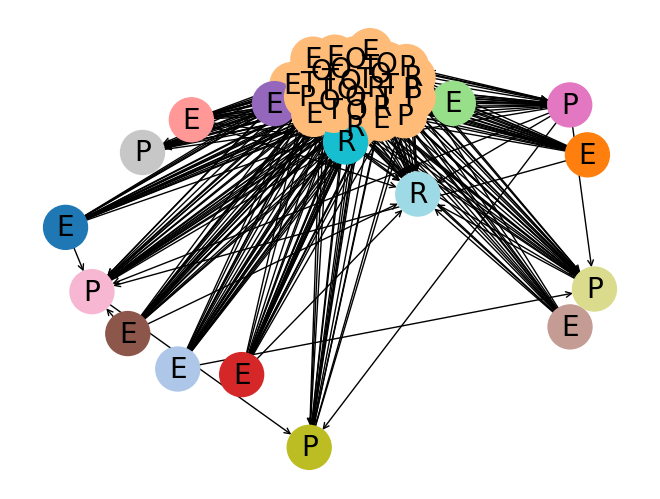

In [ ]:
# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(comm))
superpos = nx.spring_layout(G, k=1, scale=10)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, com in zip(centers, comm):
    pos.update(nx.spring_layout(nx.subgraph(G, com), k=0.5, center=center, scale=2))
nx.draw(
        G,
        pos=pos,
        node_size=1000,
        node_color=node_color,
        arrowstyle="->",
        arrowsize=10,
        with_labels=True,
        arrows=True,
        font_size=20,
        font_color="black",
        labels=labels,
        cmap=plt.cm.tab20
    )